# 2η ΕΡΓΑΣΙΑ ΜΗΧΑΝΙΚΗ ΜΑΘΗΣΗ

## Κωνσταντίνος Ηλίας Κωνσταντόπουλος p3170086

## Importing Libraries and Creating the functions

In [1]:
from skimage import io
import pandas as pd
import numpy as np
from numpy.random import random as random
import imageio
from scipy.stats import multivariate_normal
import time

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(99)

## Reading the image usinf imageio

In [2]:
im = imageio.imread('im.jpg')
x,y,z = im.shape
print(x,y,z)
im = im.reshape(x*y,z)
im = np.array(im, dtype=np.float)
im.shape

690 550 3


(379500, 3)

## Creating functions responsible for updating γ,μ,π,Σ

* Create the Gamma update 

$ \gamma(z_{nk}) = \dfrac {\pi_{k} \mathcal{N}(x_{n} | \mu_{k},\,\Sigma_{k})} { \sum_{j = 1}^{K}  \pi_{j} \mathcal{N}(x_{n} | \mu_{j},\,\Sigma_{j})}  $

In [3]:
def predict_gamma(X,K,pi,mean,cov):
    gamma = np.zeros((X.shape[0],K))

    for k in range(K):
        gamma[:,k] = multivariate_normal.pdf(X, mean=mean[k], cov=cov[k])
    
    gamma = gamma*pi
 
    sum = gamma.sum(axis=1)[:, np.newaxis]
    
    result = gamma/sum

    return result
    

* Create the Means update 

$ \mu_{k}^{new} = \dfrac {\sum_{n = 1}^{N} \gamma(z_{nk}) x_{n}} {\sum_{n = 1}^{N} \gamma(z_{nk})} $

In [4]:
def update_means(X,k,gamma):
    
    up = np.dot(gamma.T,X)
    
    summed = np.sum(gamma,axis=0).reshape((k,1))

    return up/summed

* Create the Sigma update 

$ \Sigma_{k}^{new} = \dfrac {\sum_{n = 1}^{N} \sum_{d = 1}^{D}  \gamma(z_{nk}) (x_{nd} - \mu_{kd}^{new})^{2}} {\sum_{n = 1}^{N} \gamma(z_{nk})}$

In [5]:
def update_sigma(X,k,gamma,means):
    D = X.shape[1]
    sigmas= [0 for m in range(k)]
    
    for i in range(k):
        temp_gamma = gamma[:,i].reshape((gamma.shape[0],1))
        
        summed = np.sum(temp_gamma,axis=0)*3
        
        square = np.square(X-means[i])

        up = np.sum(np.multiply(temp_gamma,square))
                                   
        val = up/summed
        
        sigmas[i] = np.reshape([[val for m in range(D)] for j in range(D)],(D,D))*np.identity(D)

    return sigmas

* Calculate the loglikelihood

$ \mathcal{L}({\pi,\mu,\Sigma}) = \sum_{n = 1}^{N} log \sum_{k = 1}^{K} \pi_{k} \mathcal{N}(x_{k} | \mu_{k},\,\Sigma_{k})  $ 

In [6]:
def update_loglikelihood(X,K,pi,mean,cov):
    pdf = np.zeros((X.shape[0],K))

    for k in range(K):
        pdf[:,k] = multivariate_normal.pdf(X, mean=mean[k], cov=cov[k]) #get N for each k
        
    pdf = pdf*pi  #π x N
    return np.sum(np.log(np.sum(pdf,axis=0)))

* Update the probabilities

$ \pi_{k}^{new} = \dfrac {\sum_{n = 1}^{N} \gamma(z_{nk})} {N}  $

In [7]:
def update_pi(X,k,gamma):
    return np.sum(gamma, axis=0)/gamma.shape[0]

* We create a method that calculates the error and translates the data in to our picture using imageio library

In [8]:
def reconstruct_image(image, mean, gamma, K):
    N = image.shape[0]
    
    #cast the values to integers
    mean = mean.astype(np.uint8)
    
    #decide which mean each pixel belongs to 
    results = np.argmax(gamma, axis=1)
    
    new_pixels = np.array([mean[i] for i in results])
    
    new_pixels = new_pixels.astype(np.uint8)
    
    #calculate the error between real pixel and best assigned means pixel 
    error = np.sum(np.square(image - new_pixels))/N
    print("the error is ",error)
    
    #convert the image back to a 3D representation
    new_pixels=np.reshape(new_pixels,(x,y,z))
    
    #output the new image
    imageio.imwrite('NewImages/K'+str(K)+'.jpg',new_pixels)

* Method to plot the cost function values 

In [9]:
def plot_costs(k,costs):
    x = range(1, len(costs)+1)
    y = costs
    plt.plot(x, y)
    plt.ylabel('cost for')
    plt.xlabel('iterations')
    plt.title('Cost Function for k='+str(k))
    plt.xticks(x)
    plt.show()

* We begin executing our code using the function defined above

K= 1  done. Needed  2  iterations


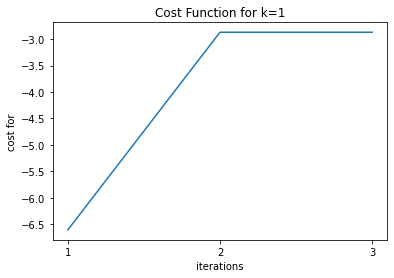

the error is  11363.850972332017
Image created
K= 2  done. Needed  21  iterations


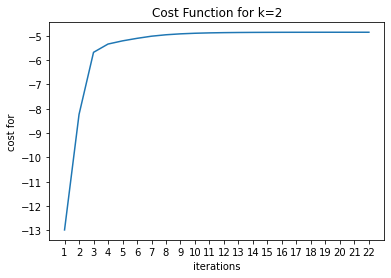

the error is  3176.855815546772
Image created
K= 4  done. Needed  162  iterations


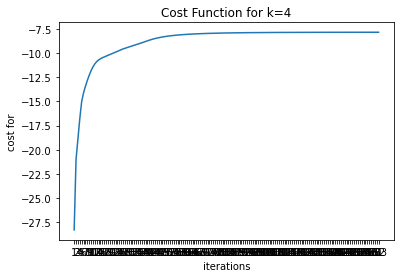

the error is  1094.154856389987
Image created
K= 8  done. Needed  199  iterations


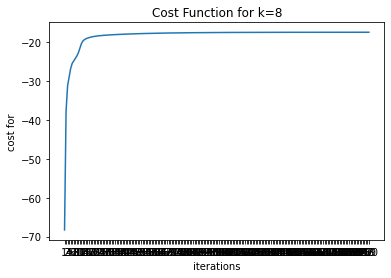

the error is  442.67531752305666
Image created
K= 16  done. Needed  32  iterations


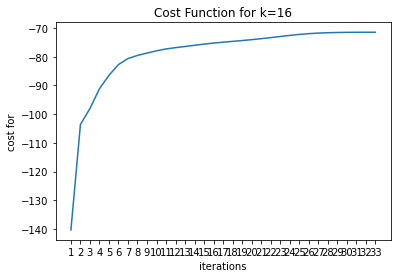

the error is  225.04287747035573
Image created
K= 32  done. Needed  300  iterations


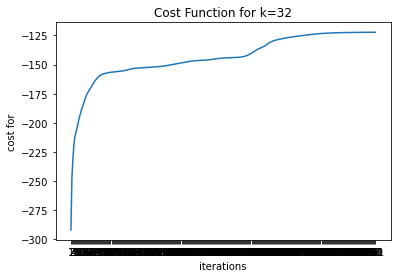

the error is  139.56168642951252
Image created
K= 64  done. Needed  300  iterations


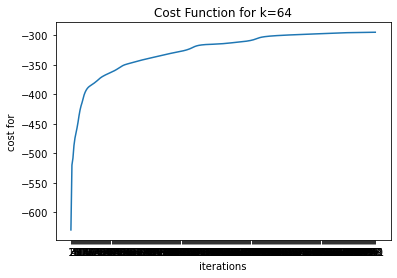

the error is  63.9076442687747
Image created
Wall time: 46min 3s


In [10]:
%%time

# We will test our EM algorithm for these k values
Ks = [1,2,4,8,16,32,64]

tol=1e-4
D = im.shape[1]

for k in Ks:
    logs=[]
    
    # Initialize π,μ,σ for each k
    pi = np.full((1,k), 1/k)
    mean = np.random.randint(0,255, (k,D))
    sigma = [np.cov(im.T)*np.identity(D)  for _ in range(k) ]
    
    
    
    logs.append(update_loglikelihood(im,k,pi,mean,sigma))
    
    for p in range(300):
        
        # E step
        gamma = predict_gamma(im,k,pi,mean,sigma)
        
        # M step
        pi=update_pi(im,k,gamma).reshape((1,k))

        mean = update_means(im,k,gamma)

        sigma = update_sigma(im,k,gamma,mean)
        
        # Save the cost 
        logs.append(update_loglikelihood(im,k,pi,mean,sigma))

        difference = logs[p+1] - logs[p]
        
        # check if everything is ok
        if( difference < 0):
            print("error in calculation")
        
        # check for convergence 
        if( abs(difference) < tol ):
            break

    print("K=",k," done. Needed ",len(logs)-1," iterations")
    plot_costs(k,logs)
    
    reconstruct_image(im, mean, gamma, k)
    
    print("Image created")
